![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px
from sklearn.ensemble import BaggingRegressor


# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
"""Funciones para la construcción del árbol"""
""" Cálculo del MSE de la bifurcación """
def mse(y_l, y_r):
    mse_l = np.mean((y_l - np.mean(y_l)) ** 2)
    mse_r = np.mean((y_r - np.mean(y_r)) ** 2)

    n_y_l=len(y_l)
    n_y_r=len(y_r)
    
    mse_total = (n_y_l * mse_l + n_y_r * mse_r) / (n_y_l + n_y_r)

    return mse_total

"""Encontrar la mejor variable y bifurcación a partir del MSE"""
def best_split(X, y):

    #Se inicializan las variables para guardar lo mejor variable, bifurcación y mse
    mejor_x, mejor_split = None, None
    mejor_mse = float('inf')

    #Se convierte a numpy array los dataframes
    X=np.array(X)
    y=np.array(y)

    #Se recorren todas las variables predictoras del modelo
    for x in range(X.shape[1]):
        splits = np.unique(X[:, x])

        #Se recorren todos los splits unicos de la variable
        for s in splits:

            #Se separan los datos según el split
            lado_izquierdo = X[:, x] <= s
            y_l = y[lado_izquierdo]
            y_r = y[~lado_izquierdo]

            #Ignorar splits con algun lado en cero
            if len(y_l) == 0 or len(y_r) == 0:
                continue
            
            #Se calcula el MSE
            mse_actual = mse(y_l, y_r)

            #Si el mse de este split es mejor se guardan
            if mse_actual < mejor_mse:
                mejor_mse = mse_actual
                mejor_x = x
                mejor_split = s

    return mejor_x, mejor_split

"""Crear el árbol hasta una profundidad determinada"""
def crear_arbol(X, y, max_depth=5, depth=0):
    
    # Parar si la profundidad alcanzó el máximo y retornar el promedio de 'y'
    if depth >= max_depth:
        return {"valor": np.mean(y)}

    # Encontrar el mejor split
    x, split = best_split(X, y)

    # Parar si el MSE  no mejora y retornar el promedio de 'y'
    if x is None:
        return {"valor": np.mean(y)}

    # Bifurcar los datos
    X=np.array(X)
    l = X[:, x] <= split
    r = ~l

    # Contruir el arbol de forma recursiva a ambos lados
    arbol_l = crear_arbol(X[l], y[l], max_depth, depth + 1)
    arbol_r = crear_arbol(X[r], y[r], max_depth, depth + 1)

    #Retornar el árbol izquierdo y derecho con la bifurcación
    return {
        "variable": x,
        "umbral": split,
        "izquierda": arbol_l,
        "derecha": arbol_r
    }

"""Predecir con el árbol"""
def predecir_arbol(X, arbol):
    #Lista para guardar predicciones
    predicciones = []
    X=np.array(X)
    #Recorrer cada una de las variables predictoras
    for x in X:
        nodo_actual = arbol

        #Mientras no sea una hoja
        while 'valor' not in nodo_actual:

            valor_x=x[nodo_actual['variable']]
            
            if valor_x <= nodo_actual['umbral']:
                nodo_actual = nodo_actual['izquierda']
            else:
                nodo_actual = nodo_actual['derecha']
        
        predicciones.append(nodo_actual['valor'])
        
    return predicciones

In [6]:
"""Calibrar la profundidad del árbol con validación cruzada en la muestra de entrenamiento (aprox 10 mins)"""
#Se crea el rango de max_depth a probar y las listas para guardar los resultados promedios de RMSE y MAE de la validación cruzada
max_depth_range = range(1, 11)
rmse=[]
mae=[]

#kFolds de 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train_np=np.array(X_train)
y_train_np=np.array(y_train)
#Para cada valor en el rango de max_depth se realiza validación cruzada. Para cada partición se entrena y se prueba el arbol y luego se calculan el RMSE y el MAE.
for md in max_depth_range:

    rmse_temp=[]
    mae_temp=[]

    #Loop para hacer la validación cruzada
    for train_index, test_index in kf.split(X_train_np):
        
        X_train_temp, X_test_temp = X_train_np[train_index], X_train_np[test_index]
        y_train_temp, y_test_temp = y_train_np[train_index], y_train_np[test_index]
        
        arbol=crear_arbol(X_train_temp,y_train_temp,md)
        y_pred=predecir_arbol(X_test_temp,arbol)
   
        rmse_temp.append(np.sqrt(mean_squared_error(y_test_temp,y_pred)))
        mae_temp.append(mean_absolute_error(y_test_temp,y_pred))

    #El RMSE y MAE de cada valor de max_depth es el promedio de las metricas individuales de la validación cruzada
    rmse.append(sum(rmse_temp) / len(rmse_temp))
    mae.append(sum(mae_temp) / len(mae_temp))

In [7]:
print(f"El menor RMSE de {min(rmse):.3f} se obtiene con un max depth igual a {rmse.index(min(rmse))+1}")

El menor RMSE de 1613.786 se obtiene con un max depth igual a 8


In [8]:
"""Grafica de RMSE y MAE vs max_depth"""

df = pd.DataFrame({
    'x': max_depth_range,
    'RMSE': rmse,
    'MAE': mae
})

fig = px.line(df, x='x', y=['RMSE', 'MAE'],
              title='RMSE y MAE vs. max_depth')
fig.show()

***
De la gráfica se puede ver que se logra un menor RMSE y MAE cuando la profundidad del árbol es igual a 8. Esta profundidad logra un buen balance entre sesgo y varianza en el set de entrenamiento.

También se puede resaltar que a medida que la profundidad aumenta, el error disminuye inicialmente, ya que el modelo es capaz de capturar mejor la complejidad de los datos. Sin embargo, a partir de cierta profundidad, el error tiende a estabilizarse, indicando que seguir incrementando la profundidad no genera mejoras significativas y podría llevar a sobreajuste.

In [9]:
#Se hace validación cruzada con la muestra completa para evaluar el desempeño general del árbol con max_depth=8 a través del RMSE y MAE
rmse_cv=[]
mae_cv=[]

#kFolds de 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Loop para validación cruzada
for train_index, test_index in kf.split(X):

    X_np=np.array(X)
    y_np=np.array(y)

    
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    #Entrenamiento del arbol con max_depth=8
    arbol_8=crear_arbol(X_train,y_train,8)
    #Predicción del árbol
    y_pred=predecir_arbol(X_test,arbol_8)

    #Se agregan los resultados de RMSE y MAE de cada fold
    rmse_cv.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_cv.append(mean_absolute_error(y_test,y_pred))
    
print(f"RMSE promedio del árbol en la muestra de test: {sum(rmse_cv)/len(rmse_cv):.3f}")
print(f"MAE promedio del árbol en la muestra de test: {sum(mae_cv)/len(mae_cv):.3f}")

RMSE promedio del árbol en la muestra de test: 1595.627
MAE promedio del árbol en la muestra de test: 1173.190


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [10]:
num_arboles=10

rmse_cv=[]
mae_cv=[]

#kFolds de 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Loop para validación cruzada
for train_index, test_index in kf.split(X):

    X_np=np.array(X)
    y_np=np.array(y)
    pred_arbol=[]
    #Conjunto de entrenamiento y test del split
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    #Loop para entrenar cada arbol de regresión para el bagging del split de la validación cruzada
    for i in range(num_arboles):
    
        #Muestra de bootstrap con reemplazo
        rng = np.random.default_rng(seed=i)  # semilla reproducible por cada árbol
        indices = rng.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_train_temp = X_train[indices]
        y_train_temp = y_train[indices]
    
        #Entrenar el árbol con max_depth=8
        arbol=DecisionTreeRegressor(max_depth=8)
        arbol.fit(X_train_temp,y_train_temp)
    
        #Predecir el árbol
        y_pred=arbol.predict(X_test)
        pred_arbol.append(y_pred)
    
    #Promedio de las predicciones del bagging
    y_pred_prom=np.mean(pred_arbol, axis=0)

    #Guarda el RMSE y MAE de cada bagging de la validación cruzada
    rmse_cv.append(np.sqrt(mean_squared_error(y_test, y_pred_prom)))
    mae_cv.append(mean_absolute_error(y_test,y_pred_prom))

print(f"RMSE del bagging manual en la muestra de test: {sum(rmse_cv)/len(rmse_cv):.3f}")
print(f"MAE del bagging manual en la muestra de test: {sum(mae_cv)/len(mae_cv):.3f}")

RMSE del bagging manual en la muestra de test: 1546.792
MAE del bagging manual en la muestra de test: 1139.018


***
Se obtiene un RMSE de 1546 y un MAE de 1138, reflejando un mejor desempeño que el árbol único calibrado en el punto anteror y probando así las ventajas de hacer este tipo de ensamblaje (lo cual confirma que el bagging ayuda a reducir la varianza del modelo y mejora su capacidad de generalización).

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

***
Si se limita el parámetro max_features del árbol del Bagging igual a log(n_features) mejora ligeramente el desempeño del modelo respecto a si no se limita. Si se compara con respecto al bagging manual, el desempeño solo mejora el MAE pero no el MSE.

In [11]:
rmse_cv=[]
mae_cv=[]

#kFolds de 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Loop para validación cruzada
for train_index, test_index in kf.split(X):

    X_np=np.array(X)
    y_np=np.array(y)

    #Conjunto de entrenamiento y test del split
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    bagreg = BaggingRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=10,bootstrap=True, oob_score=True)

    bagreg.fit(X_train, y_train)
    y_pred = bagreg.predict(X_test)

    rmse_cv.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_cv.append(mean_absolute_error(y_test,y_pred))

print(f"RMSE promedio del bagging con librearía en la muestra de test sin restricción de max_features: {sum(rmse_cv)/len(rmse_cv):.3f}")
print(f"MAE promedio del bagging con librería en la muestra de test sin restricción de max_features: {sum(mae_cv)/len(mae_cv):.3f}")

RMSE promedio del bagging con librearía en la muestra de test sin restricción de max_features: 1549.753
MAE promedio del bagging con librería en la muestra de test sin restricción de max_features: 1140.478


Ahora, con la restricción de max_features:

In [12]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_cv = []
mae_cv = []

# Calcular log2 del número de variables predictoras
import math
n_features = X.shape[1]
max_feat_log = math.floor(math.log2(n_features))  # valor entero de log2(n_features)

# K-Folds de 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop para validación cruzada
for train_index, test_index in kf.split(X):
    X_np = np.array(X)
    y_np = np.array(y)

    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # Modelo de Bagging con max_features = log2(n_features)
    bagreg = BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=8, max_features=max_feat_log),
        n_estimators=10,
        bootstrap=True,
        oob_score=True,
        random_state=42
    )

    bagreg.fit(X_train, y_train)
    y_pred = bagreg.predict(X_test)

    rmse_cv.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_cv.append(mean_absolute_error(y_test, y_pred))

print(f"RMSE promedio del bagging con librería y max_features = log2: {sum(rmse_cv)/len(rmse_cv):.3f}")
print(f"MAE promedio del bagging con librería y max_features = log2: {sum(mae_cv)/len(mae_cv):.3f}")



RMSE promedio del bagging con librería y max_features = log2: 1541.059
MAE promedio del bagging con librería y max_features = log2: 1137.929


Se obtiene un RMSE promedio de 1541.059 y un MAE promedio de 1137.929 al aplicar bagging con la librería sklearn usando 10 árboles y el parámetro max_features = log2(n_features).
Aqui se confirma que el uso de subconjuntos aleatorios de variables (max_features) en los árboles base puede seguir mejorando la generalización del modelo al reducir la correlación entre los estimadores individuales, manteniendo baja la varianza del mismo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Definición del modelo Random Forest para regresión
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

# Validación cruzada con 10 folds (cv=10) usando MSE
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Predicciones en el conjunto de prueba
y_pred = reg.predict(X_test)

# Cálculo del RMSE en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_test = mean_absolute_error(y_test, y_pred)

# Mostrar resultado
print(f"RMSE del modelo en test: {rmse:.3f}")
print(f"MAE del modelo en test: {mae_test:.3f}")

RMSE del modelo en test: 1718.666
MAE del modelo en test: 1282.473


De acuerdo con el resultado del RMSE, se puede inferir que existen algunas predicciones con errores altos. Frente al MAE, señala que el modelo se equivoca aproximadamente en $1.282 por observación. Hasta este punto se están obteniendo resultados con un peor desempeño en comparación con el modelo de Bagging con librería y con el Bagging manual, lo que refuerza la importancia de calibrar los hiperparámetros del Random Forest.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [14]:
# Calibración de n_estimators
# # Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(30, 310, 30)

# Definición de lista para almacenar la exactitud (RMSE) promedio para cada valor de n_estimators
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    rmse_scores.append(rmse)
    print(f"n_estimators: {estimator}, RMSE: {rmse:.2f}")

# Encontrar el valor óptimo de n_estimators
optimal_estimator = estimator_range[rmse_scores.index(min(rmse_scores))]
print(f"\nMejor n_estimators: {optimal_estimator} con RMSE: {min(rmse_scores):.2f}")

n_estimators: 30, RMSE: 1747.98
n_estimators: 60, RMSE: 1744.17
n_estimators: 90, RMSE: 1743.56
n_estimators: 120, RMSE: 1743.12
n_estimators: 150, RMSE: 1741.67
n_estimators: 180, RMSE: 1742.07
n_estimators: 210, RMSE: 1742.35
n_estimators: 240, RMSE: 1741.92
n_estimators: 270, RMSE: 1741.50
n_estimators: 300, RMSE: 1741.26

Mejor n_estimators: 300 con RMSE: 1741.26


A medida que aumenta el n_estimators, el RMSE disminuye. Sin embargo, desde 180 en adelante ya son estables. n_estimators de 300 da el menor RMSE. En la gráfica se confirma dicha información:

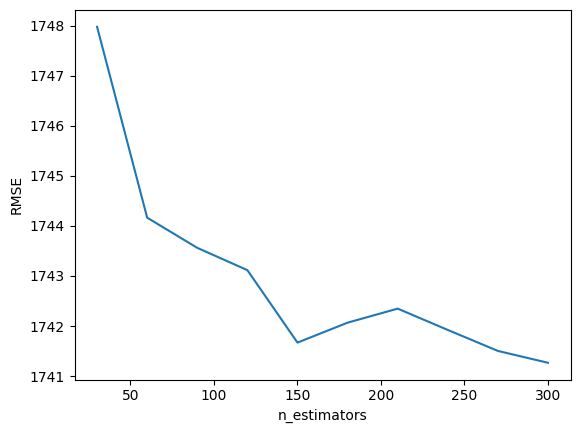

In [15]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [16]:
# Calibración de max_features
# # Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X.shape[1] + 1)

# Definición de lista para almacenar la exactitud (RMSE) promedio para cada valor de max_features
rmse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=300, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    rmse_scores.append(rmse)
    print(f"max_features: {feature}, RMSE: {rmse:.2f}")

# Encontrar el valor óptimo de max_features
optimal_feature = feature_range[rmse_scores.index(min(rmse_scores))]
print(f"\nMejor max_features: {optimal_feature} con RMSE: {min(rmse_scores):.2f}")

max_features: 1, RMSE: 1770.69
max_features: 2, RMSE: 1770.16
max_features: 3, RMSE: 1769.97
max_features: 4, RMSE: 1767.14
max_features: 5, RMSE: 1762.67
max_features: 6, RMSE: 1759.10
max_features: 7, RMSE: 1753.39
max_features: 8, RMSE: 1746.97
max_features: 9, RMSE: 1741.26

Mejor max_features: 9 con RMSE: 1741.26


A medida que aumenta el valor de max_features, el error promedio (RMSE) disminuye. El mejor resultado lo da max_features = 9, con el menor RMSE. La siguiente gráfica permite visualizar el resultado.

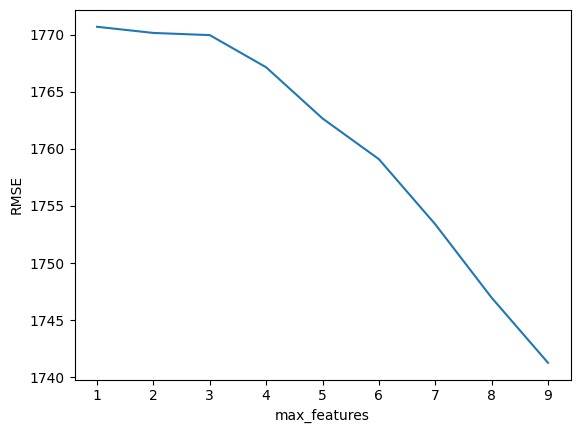

In [17]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.show()

In [18]:
# Calibración de max_depth
# Valores a probar para max_depth
depth_range = range(2, 10)

# Lista para guardar los RMSE promedio
rmse_scores = []

# Validación cruzada para cada valor de max_depth
for depth in depth_range:
    reg = RandomForestRegressor(n_estimators=300, max_depth=depth, random_state=1, n_jobs=-1)
    scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    rmse_scores.append(rmse)
    print(f"max_depth: {depth}, RMSE: {rmse:.2f}")

# Encontrar el valor óptimo de max_depth
optimal_depth = depth_range[rmse_scores.index(min(rmse_scores))]
print(f"\nMejor max_depth: {optimal_depth} con RMSE: {min(rmse_scores):.2f}")

max_depth: 2, RMSE: 2052.79
max_depth: 3, RMSE: 1833.46
max_depth: 4, RMSE: 1696.48
max_depth: 5, RMSE: 1612.68
max_depth: 6, RMSE: 1566.17
max_depth: 7, RMSE: 1543.65
max_depth: 8, RMSE: 1535.94
max_depth: 9, RMSE: 1540.56

Mejor max_depth: 8 con RMSE: 1535.94


In [19]:
# Definición del modelo con los parámetros max_features=9 y n_estimators=300
reg = RandomForestRegressor(n_estimators=300, max_features=9, max_depth=8, random_state=1, n_jobs=-1)
reg.fit(X_train, y_train)

# Validación cruzada con 10 folds (cv=10) usando MSE
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Predicciones en el conjunto de prueba
y_pred = reg.predict(X_test)

# Cálculo del RMSE en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae_test = mean_absolute_error(y_test, y_pred)

# Mostrar resultado
print(f"RMSE del modelo en test: {rmse:.3f}")
print(f"MAE del modelo en test: {mae_test:.3f}")

RMSE del modelo en test: 1525.743
MAE del modelo en test: 1128.304


Al utilizar el modelo con 300 árboles, se obtiene un modelo con mayor estabilidad y capacidad de generalización. Además, en cada división de los árboles, se seleccionan aleatoriamente 9 variables predictoras, lo cual introduce diversidad en las particiones y contribuye a reducir el sobreajuste.
En cuanto a las métricas de desempeño, el RMSE refleja que el modelo penaliza más fuertemente los outliers, mientras que el MAE indica que, en promedio, el modelo se equivoca aproximadamente $1,128 por predicción, lo que representa un nivel de error aceptable en relación con el rango de precios del conjunto de datos.

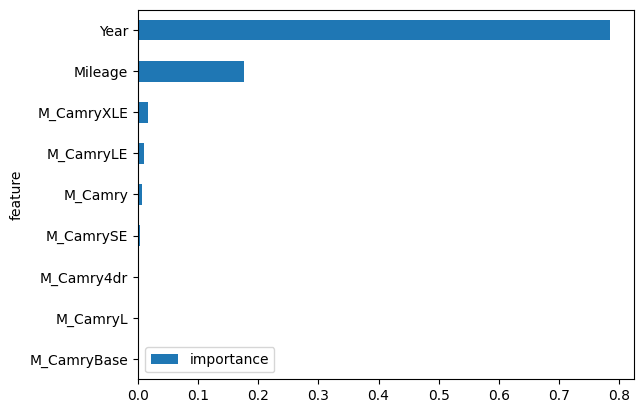

In [20]:
# Impresión de resultados de desempeño del modelo
feature_cols = X.columns
pd.DataFrame({'feature':feature_cols, 'importance':reg.feature_importances_}).sort_values('importance').plot(x='feature', y='importance', kind='barh')
plt.show()

Según la gráfica de importancia de variables obtenida del modelo Random Forest, la variable Year (año del vehículo) es, con diferencia, el predictor más influyente en la estimación del precio, lo cual es coherente con el hecho de que vehículos más nuevos tienden a tener mayor valor de mercado. Le sigue Mileage (kilometraje), lo que también resulta esperable, ya que un menor recorrido suele asociarse a mejor estado del vehículo.

Las demás variables presentan contribuciones significativamente menores, lo que sugiere que su efecto sobre el precio es más limitado o bien está parcialmente explicado por las variables principales.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [21]:
# Importación y definición de modelo XGBRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Entrenamiento del modelo
reg = XGBRegressor(random_state=42)
reg.fit(X_train, y_train)

# Predicciones
y_pred = reg.predict(X_test)

# Evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Resultados
print(f"RMSE del modelo XGBoost: {rmse:.2f}")
print(f"MAE del modelo XGBoost: {mae:.2f}")



RMSE del modelo XGBoost: 1573.00
MAE del modelo XGBoost: 1163.91


Teniendo en cuenta el RMSE, el modelo comete errores promedio de aproximadamente 1.573.
El MAE, indica que, en promedio, el modelo se equivoca por 1.164 el predecir el valor real.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Rangos de valores para calibrar
learning_rates = [0.01, 0.05, 0.1, 0.2]
gammas = [0, 1, 5]
colsample_values = [0.3, 0.5, 0.7, 1.0]

# Guardar resultados
results = []

for lr in learning_rates:
    for gamma in gammas:
        for colsample in colsample_values:
            model = XGBRegressor(
                learning_rate=lr,
                gamma=gamma,
                colsample_bytree=colsample,
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
            scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
            rmse = np.sqrt(-scores.mean())
            results.append((lr, gamma, colsample, rmse))
            print(f"lr: {lr}, gamma: {gamma}, colsample_bytree: {colsample}, RMSE: {rmse:.2f}")

# Encontrar combinación óptima
best = min(results, key=lambda x: x[3])
print(f"\nMejor combinación -> learning_rate: {best[0]}, gamma: {best[1]}, colsample_bytree: {best[2]}, RMSE: {best[3]:.2f}")


lr: 0.01, gamma: 0, colsample_bytree: 0.3, RMSE: 2892.97
lr: 0.01, gamma: 0, colsample_bytree: 0.5, RMSE: 2373.85
lr: 0.01, gamma: 0, colsample_bytree: 0.7, RMSE: 2099.86
lr: 0.01, gamma: 0, colsample_bytree: 1.0, RMSE: 2048.65
lr: 0.01, gamma: 1, colsample_bytree: 0.3, RMSE: 2892.97
lr: 0.01, gamma: 1, colsample_bytree: 0.5, RMSE: 2373.85
lr: 0.01, gamma: 1, colsample_bytree: 0.7, RMSE: 2099.86
lr: 0.01, gamma: 1, colsample_bytree: 1.0, RMSE: 2048.65
lr: 0.01, gamma: 5, colsample_bytree: 0.3, RMSE: 2892.97
lr: 0.01, gamma: 5, colsample_bytree: 0.5, RMSE: 2373.85
lr: 0.01, gamma: 5, colsample_bytree: 0.7, RMSE: 2099.86
lr: 0.01, gamma: 5, colsample_bytree: 1.0, RMSE: 2048.65
lr: 0.05, gamma: 0, colsample_bytree: 0.3, RMSE: 1712.92
lr: 0.05, gamma: 0, colsample_bytree: 0.5, RMSE: 1532.90
lr: 0.05, gamma: 0, colsample_bytree: 0.7, RMSE: 1514.59
lr: 0.05, gamma: 0, colsample_bytree: 1.0, RMSE: 1520.36
lr: 0.05, gamma: 1, colsample_bytree: 0.3, RMSE: 1712.92
lr: 0.05, gamma: 1, colsample_b

Luego de realizar la calibración de los parámetros learning_rate, gamma y colsample_bytree, se obtuvo la mejor combinación con los siguientes valores:
learning_rate: 0.05
gamma: 0
colsample_bytree: 0.7
RMSE: 1514.59

Esta combinación generó un mejor desempeño frente al modelo XGBoost por defecto, lo que indica que una adecuada calibración puede mejorar considerablemente la capacidad predictiva del modelo.

learning_rate: controla la velocidad de aprendizaje del modelo. Un valor 0.05 es bajo, lo que permite un aprendizaje más gradual y reduce el riesgo de sobreajuste, aunque requiere más árboles para converger. En este caso, logró mejorar la generalización del modelo.

gamma: regula la complejidad del modelo al controlar si una división de un nodo debe realizarse. Un gamma de 0 indica que el modelo no penaliza la creación de particiones, permitiendo una mayor profundidad en los árboles. Esto puede ser beneficioso si los datos requieren modelos más complejos para captar patrones.

colsample_bytree: determina la proporción de variables que se seleccionan aleatoriamente para cada árbol. Un valor de 0.7 (se usa solo el 70% de las variables en cada árbol) introduce diversidad en los árboles y reduce la varianza, ayudando a evitar el sobreajuste. En este caso, fue clave para lograr un mejor desempeño.

En conclusión, calibrar estos hiperparámetros permitió obtener un modelo más preciso y robusto, con un RMSE inferior al modelo base de XGBoost.

RMSE del modelo XGBoost calibrado: 1502.67
MAE del modelo XGBoost calibrado: 1106.40


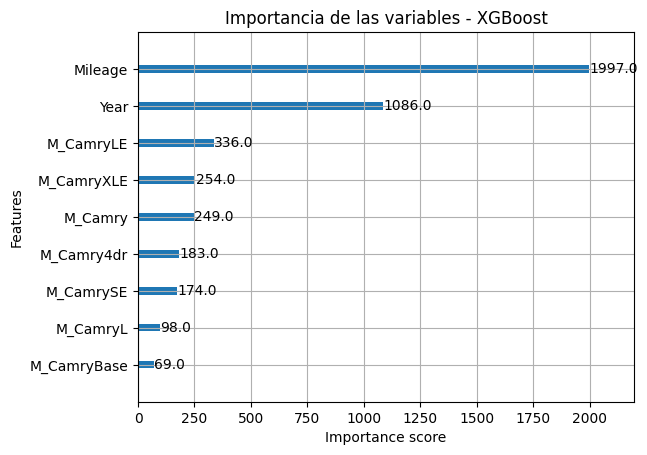

In [23]:
# Entrenamiento del modelo con los mejores hiperparámetros encontrados
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Modelo ajustado
reg = XGBRegressor(learning_rate=0.05, gamma=0, colsample_bytree=0.7, random_state=1)
reg.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = reg.predict(X_test)

# Cálculo de métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE del modelo XGBoost calibrado: {rmse:.2f}")
print(f"MAE del modelo XGBoost calibrado: {mae:.2f}")

# Asegurar que los nombres reales estén asignados al booster
reg.get_booster().feature_names = list(X.columns)

# Gráfico de importancia de variables
plot_importance(reg)
plt.title("Importancia de las variables - XGBoost")
plt.show()


    ### Punto 8 - Comparación y análisis de resultados
    En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

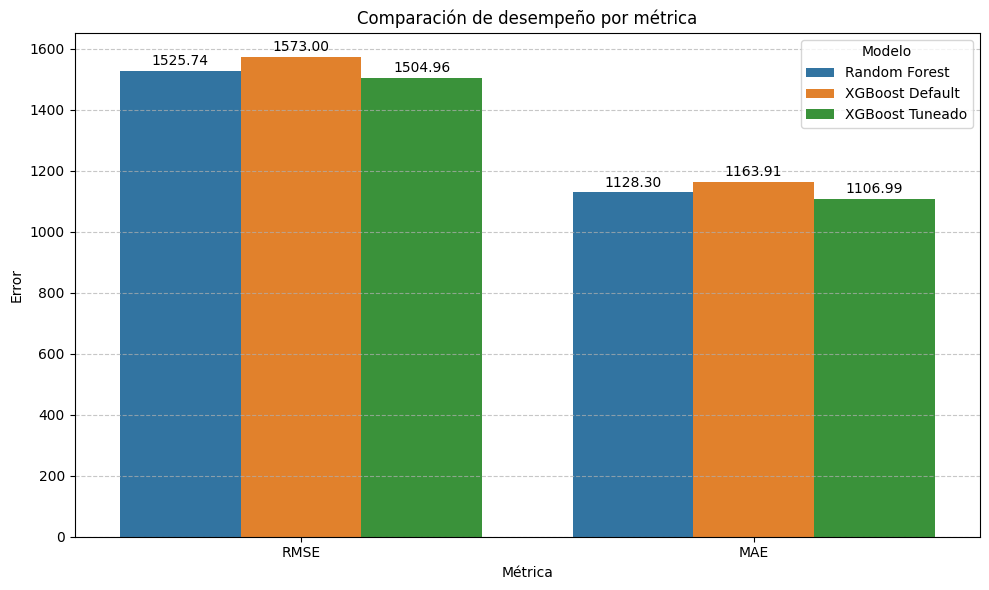

In [24]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Entrenamiento de modelos y predicciones
results = []

# Random Forest
rf_model = RandomForestRegressor(n_estimators=300, max_depth=8, max_features=9, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
mae_rf = mean_absolute_error(y_test, rf_pred)
results.append(('Random Forest', 'RMSE', rmse_rf))
results.append(('Random Forest', 'MAE', mae_rf))

# XGBoost por defecto
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae_xgb = mean_absolute_error(y_test, xgb_pred)
results.append(('XGBoost Default', 'RMSE', rmse_xgb))
results.append(('XGBoost Default', 'MAE', mae_xgb))

# XGBoost tuneado
xgb_tuned = XGBRegressor(learning_rate=0.05, gamma=0, colsample_bytree=0.7, n_estimators=100, random_state=42, n_jobs=-1)
xgb_tuned.fit(X_train, y_train)
xgb_tuned_pred = xgb_tuned.predict(X_test)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, xgb_tuned_pred))
mae_xgb_tuned = mean_absolute_error(y_test, xgb_tuned_pred)
results.append(('XGBoost Tuneado', 'RMSE', rmse_xgb_tuned))
results.append(('XGBoost Tuneado', 'MAE', mae_xgb_tuned))

# Crear DataFrame para graficar
df = pd.DataFrame(results, columns=['Modelo', 'Métrica', 'Valor'])

# Gráfico con etiquetas
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=df)
plt.title('Comparación de desempeño por métrica')
plt.ylabel('Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar etiquetas a las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()




### Punto 8 - Comparación y análisis de resultados

La comparación de los modelos muestra que el modelo con mejor desempeño fue el **XGBoost con parámetros calibrados** (learning_rate: 0.05, gamma: 0, colsample_bytree: 0.7), obteniendo el menor **RMSE** (1502.67) y el menor **MAE** (1106.40). Esto indica que, en promedio, este modelo comete errores más pequeños tanto en términos de desviaciones absolutas como cuadráticas.

Por su parte, el modelo con menor desempeño fue el **XGBoost sin calibrar**, con un RMSE de 1573.00 y un MAE de 1163.91. Aunque sus resultados no son malos, muestran que la calibración de hiperparámetros puede mejorar notablemente la capacidad predictiva del modelo.

El **Random Forest** se ubicó en un punto intermedio, con un RMSE de 1525.74 y un MAE de 1128.30. Este modelo se desempeñó mejor que el XGBoost sin calibrar, pero fue superado por el XGBoost calibrado.

se concluye que calibrar entonces el modelo XGBoost:
- Permite un mayor control sobre el aprendizaje mediante hiperparámetros como el `learning_rate`, `gamma` y `colsample_bytree`.
- Logra un mejor ajuste al reducir tanto errores grandes (RMSE) como errores promedio (MAE).
- Puede superar modelos por defecto si se ajusta correctamente.


